**VGG-16 IMPLEMENTATION PYTORCH**

***1. LOADING IMPORTANT LIBRARIES***

CIFAR-10 Classifier Using CNN in PyTorch

First published: 30 Nov 2018
Last updated: 30 Nov 2018
Introduction

In this notebook we will use PyTorch to construct a convolutional neural network. We will then train the CNN on the CIFAR-10 data set to be able to classify images from the CIFAR-10 testing set into the ten categories present in the data set.
CIFAR-10

The CIFAR-10 data set is composed of 60,000 32x32 colour images, 6,000 images per class, so 10 categories in total. The training set is made up of 50,000 images, while the remaining 10,000 make up the testing set.

The categories are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck.

More information regarding the CIFAR-10 and CIFAR-100 data sets can be found here.

https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/

In [1]:

# from torchvision.transforms import ToTensor
# # from torchvision import transforms
# from torchvision.utils import save_image

# #%matplotlib inline
# from sklearn.metrics import classification_report, confusion_matrix


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
## 
## The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, 
## with 6000 images per class. There are 50000 training images and 10000 test images. 
## https://www.cs.toronto.edu/~kriz/cifar.html

tranform_train = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(p=0.7), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
tranform_test = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#preparing the train, validation and test dataset
torch.manual_seed(43)
train_ds = CIFAR10("../data/", train=True, download=True, transform=tranform_train) #40,000 original images + transforms
val_size = 10000 #there are 10,000 test images and since there are no transforms performed on the test, we keep the validation as 10,000
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size]) #Extracting the 10,000 validation images from the train set
test_ds = CIFAR10("../data/", train=False, download=True, transform=tranform_test) #10,000 images


batch_size = 64

#passing the train, val and test datasets to the dataloader
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


***2.1. PREVIEWING THE TRAIN DATASET***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 224, 224])


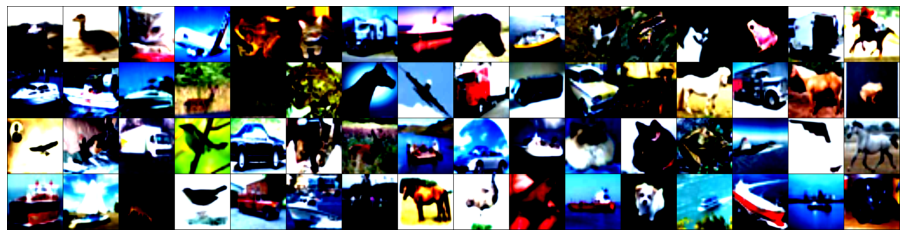

In [3]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

***2.2. PREVIEWING THE TEST DATASET***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 224, 224])


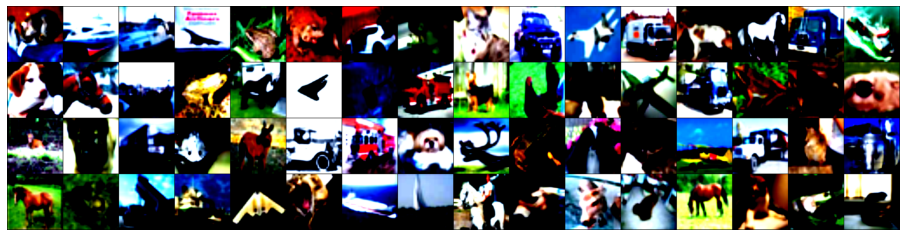

In [4]:
for images, _ in test_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

***2.3. PREVIEWING THE VAL DATASET***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 224, 224])


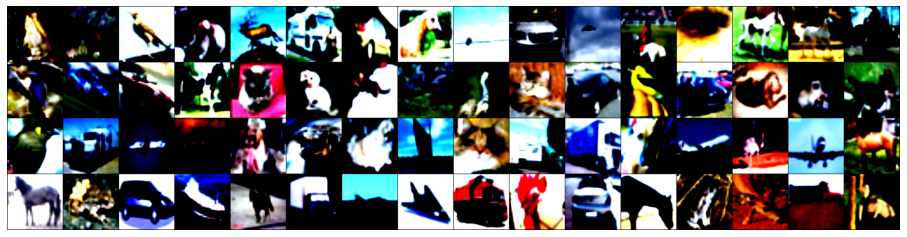

In [5]:
for images, _ in val_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [6]:
BATCH_SIZE = 10

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root="../data/", 
                                        train=True,
                                        download=True, 
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='../data/', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


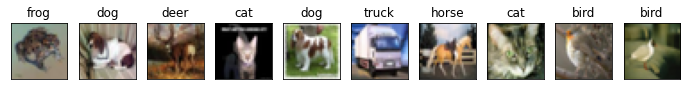

In [7]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

***3. BUILDING THE MODEL***

### Defining the Convolutional Neural Network

The network has the following layout,

Input > Conv (ReLU) > MaxPool > Conv (ReLU) > MaxPool > FC (ReLU) > FC (ReLU) > FC (SoftMax) > 10 outputs

where:

Conv is a convolutional layer, ReLU is the activation function, MaxPool is a pooling layer, FC is a fully connected layer and SoftMax is the activation function of the output layer.


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0)
        #conv1 expects 3 input channels and will convolve 6 filters each of size 3x5x5
        #Since padding is set to 0 and stride is set to 1, the output size is 6x28x28, because (32−5)+1=28
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        #The first down-sampling layer uses max pooling with a 2x2 kernel and stride set to 2
        #This effectively drops the size from 6x28x28 to 6x14x14.
        
        #self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)

        #conv2 expects 6 input channels and will convolve 16 filters each of size 6x5x5. 
        #Since padding is set to 0 and stride is set to 1, the output size is 16x10x10, because (14−5)+1=10. 
        #This layer therefore has ((5×5×6)+1)×16=2416 parameters.
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)#First Fully-Connected Layer
        #The output from the final max pooling layer needs to be flattened 
        #so that we can connect it to a fully connected layer. 
        #This is achieved using the torch.Tensor.view method. 
        #By specifying -1 the method will automatically infer the number of rows required. 
        #This is done to handle the mini-batch size of data.
        
        self.fc2 = nn.Linear(120, 84) #Second Fully-Connected Layer
        #The output from the first fully-connected layer is connected 
        #to another fully connected layer with 84 nodes, using ReLU as an activation function. 
        #This layer thus needs (120+1)×84=10164 parameters.
        
        self.fc3 = nn.Linear(84, 10)#Output Layer
        #The last fully-connected layer uses softmax and is made up of ten nodes, 
        #one for each category in CIFAR-10. This layer requires (84+1)×10=850 parameters.
        

    def forward(self, x):
        #print(f' x.size() {x.size()}') # x.size() torch.Size([10, 3, 32, 32])
        
        ##x = self.maxpool(F.relu(self.conv1(x))) #First Convolutional Layer>First Max-Pooling Layer
        ##OR
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        #print(f' b.size() {x.size()}') #  b.size() torch.Size([10, 6, 14, 14])
        
        ##x = self.maxpool(F.relu(self.conv2(x))) #Second Convolutional Layer>Second Max-Pooling Layer
        ##OR
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        #print(f' c.size() {x.size()}') #  c.size() torch.Size([10, 16, 5, 5])
                    
        x = x.view(-1, 16 * 5 * 5) 
        #print(f' d.size() {x.size()}')  #d.size() torch.Size([10, 400])
         
        x = F.relu(self.fc1(x))
        #print(f' e.size() {x.size()}') #  e.size() torch.Size([10, 120])
        x = F.relu(self.fc2(x))
        #print(f' f.size() {x.size()}') #  f.size() torch.Size([10, 84])
        x = self.fc3(x)
        #print(f' h.size() {x.size()}') #  h.size() torch.Size([10, 10])
        
 
        return x
    

***4. PREPARE THE MODEL FOR TRAINING***

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
print(device)

model = Net() #to compile the model
#model = model.to(device=device) #to send the model for training on either cuda or cpu
#model = model.to(device=dce) #to send the model for training on either cuda or cpu

## PRINT MODEL
print(f'====================================================')
print(model)

### PRINT model.named_parameters
print(f'====================================================')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)


        
learning_rate=0.001
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr= learning_rate) #Adam seems to be the most popular for deep learning

        

cuda
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
conv1.weight tensor([[[[ 3.6717e-02,  5.5025e-02,  1.0062e-02, -8.2243e-02, -8.5070e-03],
          [-1.1265e-01,  1.0018e-01, -7.7802e-02,  9.3837e-02, -1.4818e-02],
          [ 4.2322e-02, -9.1049e-02, -5.7643e-02,  4.5439e-02,  9.0252e-02],
          [-7.6960e-02, -8.2292e-02, -8.4839e-02,  3.9370e-02, -8.2541e-02],
          [-4.9348e-03, -2.4688e-02, -5.9410e-02, -9.1235e-02,  1.1281e-01]],

         [[ 3.5218e-02,  8.8473e-02, -6.3698e-02, -8.0848e-02, -5.6973e-02],
          [-4.6177e-02,  7.2816e-03,  5.1653e-02, -1.0089e-01,  4.1466e-02],
          [-9.1007e-02,  6.1757e-02, -6.5842

***5. TRAINING***

In [10]:
EPOCHS = 1

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print(f'EPOCHS {epoch}')
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            
            print('    [%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            print(f'   batch_index/ len of trainlaoder {i}/{len(trainloader)}')
            running_loss = 0.0
            

print('Finished Training.')



EPOCHS 0
    [1,  2000] loss: 1.695
   batch_index/ len of trainlaoder 1999/5000
    [1,  4000] loss: 1.430
   batch_index/ len of trainlaoder 3999/5000
Finished Training.


***6.SAVING THE MODEL AND USING IT FOR THE TEST SET***

In [11]:
torch.save(model.state_dict(), "cifar-10-cnn-model.pt")
print('Saved model parameters to disk.')

Saved model parameters to disk.


tensor([[-1.4243, -2.2251, -0.4005,  1.6648, -0.7932,  0.7250, -0.2306, -1.0680,
         -1.7749, -2.1676],
        [ 3.0918,  4.2723, -4.7438, -5.0605, -5.3072, -8.4440, -6.9432, -7.1323,
          5.2234,  2.6394],
        [ 1.5026,  1.6539, -1.4359, -2.2993, -2.2614, -3.8797, -3.5020, -3.2892,
          2.3911,  0.5153],
        [ 3.6928, -0.0633, -0.3688, -3.3516, -1.1524, -5.3539, -3.4981, -3.1366,
          1.8382, -0.4733],
        [-4.0786, -3.6289,  0.6161,  0.7907,  2.0801,  0.0600,  2.6999, -1.5715,
         -4.7990, -4.4511],
        [-1.4048, -1.0631,  0.1057, -0.7664,  0.8300, -0.8160,  1.7085, -0.6613,
         -2.2629, -1.8376],
        [-0.9281,  2.0738, -1.2121, -0.6048, -2.7795, -1.3528, -1.7644, -2.1578,
         -0.9188,  0.9740],
        [-1.9341, -4.0167,  1.9080, -0.4261,  1.9424, -1.1855,  2.3711, -1.9100,
         -3.1452, -4.4664],
        [-1.5717, -3.6213,  0.1403,  2.0169, -0.7941,  1.3521, -0.6226, -0.6845,
         -3.1692, -3.1618],
        [-0.6910,  

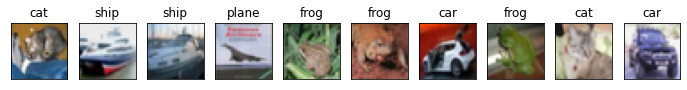

In [12]:
#Testing the Network

dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    

outputs = model(images)

print(outputs)

sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)
print(sm_outputs)


probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))
    
    

***7. TESTING***

Model accuracy on 10000 test images: 53.82%
Category   - Accuracy
plane      - 60.9
car        - 66.4
bird       - 30.1
cat        - 48.5
deer       - 38.5
dog        - 37.7
frog       - 65.3
horse      - 67.1
ship       - 67.0
truck      - 56.7


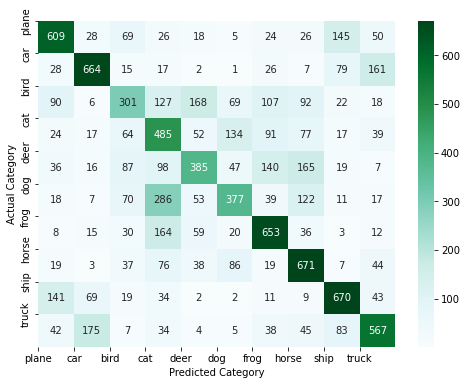

In [13]:
##Predicting the Category for all Test Images

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))


print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

    

fig, ax = plt.subplots(1,1,figsize=(8,6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap='BuGn', ax=ax)
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()        

